# SVI & COVID

## Summary

The CDC's social vulnerability index (SVI) is a scale that predicts the vulnerability of a population in the event of an emergency or natural disaster. COVID is the first global pandemic since the development of this measure. We will evaluate the association between SVI score and COVID case count in San Antonio, Texas. Features from this measure will be incorporated into a predictive model that can be used to guide recovery resource prioritization.



**Goals**      
1. Evaluate association between SVI score and COVID case count in San Antonio, TX     
2. Build a model based SVI score component features that can predict COVID cases by census tract within San Antonio, TX
3. Complete same evaluation and models for Dallas
4. Is there a difference between San Antonio and Dallas results?


### Problem Statement

Background
The SVI (Social Vulnerability Index) was developed to help city governments and first responders predict areas that are particularly vulnerable in emergency situations so that resources can be prioritized to help areas at high risk (Citation CDC Website). The CDC’s Social Vulnerability Index (CDC SVI) uses 15 U.S. census variables to classify census tracts with a composite score between 0 and 1 (lower scores = less vulnerability, higher score = greater vulnerability. This socre is calculated by first ranking every census tract, in every country, in every state, in the United States. Those ranked tracks are then broken up to 4 themes (socioeconomic status, household composition and disability, minority status and language, household type and transportation) and reclassified. This overall score is then tallied by summing the themed percentiles and ranked on a score between 0 and 1.

While SVI was designed to help city goverments repsond to emergency situations, the efficacy of the systems has never been tested on in response to a global pandemic. COVID-19 is the disease caused by a new coronavirus called SARS-CoV-2. WHO first learned of this new virus on 31 December 2019, following a report of a cluster of cases of ‘viral pneumonia’ in Wuhan, People’s Republic of China. (Citation WHO). As of 9 December 2020, more than 68.4 million cases have been confirmed, with more than 1.56 million deaths attributed to COVID-19.




### Work Plan

*Now that you have a clear idea of what you are trying to accomplish, you need to find a data source. Think of this as working through a maze forwards and backwards at the same time. At the start you have any number of data sets available to work with (and the whole Internet to search and scrape), and at the end is the hypothetical data set that would answer your question immediately if you had it.*

- What data, if you had it, would solve your problem right away?
    - Cases count per 100K by census tract nationally would be ideal
- What data do you have access to?
    - Have SVI from CDC by census track
    - Have Bexar county case count per 100K by zip code for single date 12/8/20
- What additional data would be good to have?
    - be great to have more historical data
- What data would be impossible to collect?
    - due to privacy/panic concerns case data at the census tract level is not being published for open access
- What are the best proxies you can find for unavailable or impossible data?
    - find a way to translate from census tract to zip code
- What are the legal or ethical issues you might run into if you were to try to collect all of the types of data you would like to work with?
    - considered web scraping for zip code level data where specific information is not available
    - likely better to hard code existing data that is publicly available

*Of course you need to make a plan to turn your data into the solutions you need. Think of what type of problem this is, what models are commonly used for those types of problems, what types of data those models require and special considerations that may need to be made. Do your homework and find out what approaches other people are using on similar tasks.*

- What ML paradigm are you working in? (Classification, Regression, Clustering, etc)
    - Regression
- What models are commonly used in this task?
    - Linear Regression, LassoLars, Polynomial Features, Tweedie Regressor
* What other solutions are being tried in this field?
* What special considerations need to be taken when dealing with these models? (i.e., imbalanced classes, text preprocessing, data leakage, etc)
* How will you know that your models work?
* How will you recognize and diagnose cases where the predictions are incorrect?

## Imports


In [1]:
import pandas as pd
import seaborn as sns
import wrangle
import explore
import model_MAE

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from scipy import stats

# Acquire & Prepare

- SVI data from the CDC's website
- downloaded COVID data for San Antonio and Dallas from the cities respective COVID data web portals
- HUD crosswalk provided a guide to transform the data
    - complicated because of overlap in census tracts and zip codes
    - found the Zip code that accounted for the highest percentage of addresses within the tract and assigned that as the sole Zip code for the tract
    - the ratio of addresses for the census tract was then used to calculate a cases per 100K measure for each tract 
- selected 29 features and renamed for clarity
- verified no null values to address
- military bases were removed from the data frame
- raw SVI score binned
    - bin_svi column = text label (low, low-mod, mod-high, high)
    - rank_svi column = numeric representation of SVI (1 representing a high score, 4 representing a low score)
- numeric columns with values greater than 4 were scaled using sklearn's MinMaxScaler
- six data frames returned at then end of wrangle including *train_explore* for exploration and individual scaled data frames for modeling  *X_train_scaled, y_train, X_test_scaled, y_test*.

In [2]:
import acquire_dallas

In [3]:
dallasdf = acquire_dallas.get_dallas_data()
dallasdf.head()

,zip,county,population,covid_count_median,cases_per_100k
0,75254,Dallas,23253,616,2649
1,75253,Dallas,18450,1846,10005
2,75252,Dallas,24112,616,2555
3,75251,Dallas,2331,616,26426
4,75249,Dallas,13373,616,4606


In [4]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_dallas_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(246, 25) (62, 25)


# Explore

Exploration focuses on answering questions regarding the relationship between the CDC's range category SVI score and cases of COVID-19 per 100k.

- Visualize cases per 100K by binned SVI value
    - Appear to be distinct
    - Will conduct parametric ANOCA (Kruskal) test to confirm
- Verify raw SVI score relationship to cases per 100K
    - will conduct Pearson's R correlation test
- Explore distribution of casses per 100K with SVI score
- Explore distribution of flags by SVI score


## Hypothesis Testing

### Question One: Is there a correlation between the CDC's Range Category SVI Score and COVID-19 Infection Cases per 100k Individuals?

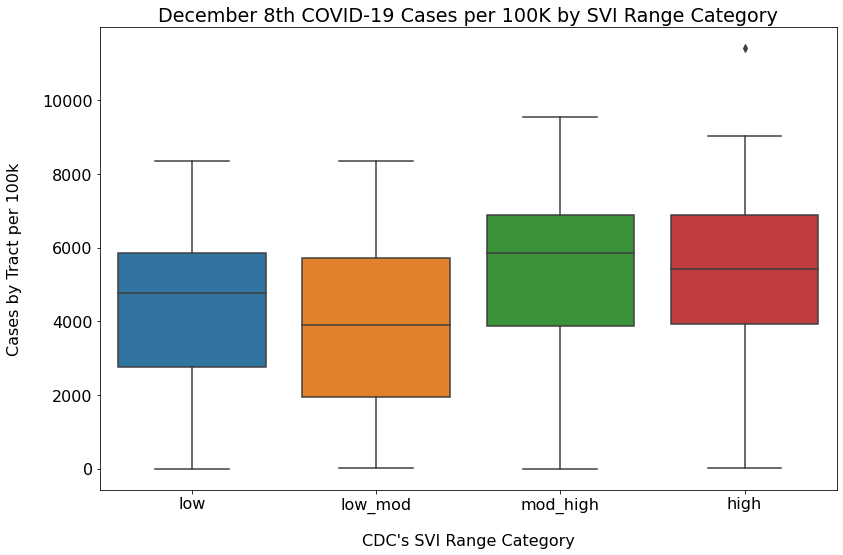

In [5]:
explore.sns_boxplot(train_exp)

**Takeaway:**
`There appears to be a correlation between COVID-19 Count and SVI Category. Next step is Hypothesis testing between categories to validate statistical significance`

In [6]:
# Mean COVID-19 Count By CDC's SVI Category
All = round(train_exp.tract_cases_per_100k.mean(),5)
low = round((train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k.mean(),5)
low_mod = round((train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k.mean(),6)
mod_high = round((train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k.mean(),6)
high = round((train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k.mean(),6)

print(f'The average number of cases per 100k for all CDC SVI Range Categories is {All}') 
print(f'The average number of cases per 100k for CDC SVI Range Category (low) is {low}')
print(f'The average number of cases per 100k for CDC SVI Range Category (low_mod) is {low_mod}')
print(f'The average number of cases per 100k for CDC SVI Range Category (mod_high) is {mod_high}')
print(f'The average number of cases per 100k for CDC SVI Range Category (high) is {high}')

The average number of cases per 100k for all CDC SVI Range Categories is 4849.86647
The average number of cases per 100k for CDC SVI Range Category (low) is 4381.45776
The average number of cases per 100k for CDC SVI Range Category (low_mod) is 3874.868917
The average number of cases per 100k for CDC SVI Range Category (mod_high) is 5289.058653
The average number of cases per 100k for CDC SVI Range Category (high) is 5343.016472


In [7]:
low = (train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k
low_mod = (train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k
mod_high = (train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k
high = (train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k
alpha = 0.01
null = "Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories "
alternate = "Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories "
explore.kruskal_test(low, low_mod, mod_high, high, null, alternate, alpha)

f= 17.37919795944776
p= 0.0005905152957812457


We reject the null that: 
 Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories 


We move forward with the alternative hypothesis that: 
 Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories 


**Takeaway:**
`We can state with 99% certainty that there is a statistically significant difference between all of the CDC SVI Range Categories`

### Question Two: Is there a correlation between raw_svi and cases per 100k?

In [8]:
raw_svi = train_exp.raw_svi
cases_per_100k = train_exp.tract_cases_per_100k
alpha = 0.01
null = "There is no statistically significant difference betweeen raw_svi and cases per 100K "
alternate = "There is a statistically significant difference betweeen raw_svi and cases per 100K"
explore.pearson(raw_svi, cases_per_100k, null, alternate, alpha)

r= 0.1939522548393363
p= 0.0022461351772073666


We reject the null that: 
 There is no statistically significant difference betweeen raw_svi and cases per 100K 


We move forward with the alternative hypothesis that: 
 There is a statistically significant difference betweeen raw_svi and cases per 100K


**Takeaway:**
`We can state with 99% certainty that there is a statistically significant difference between ?????`

## Distribution Exploration

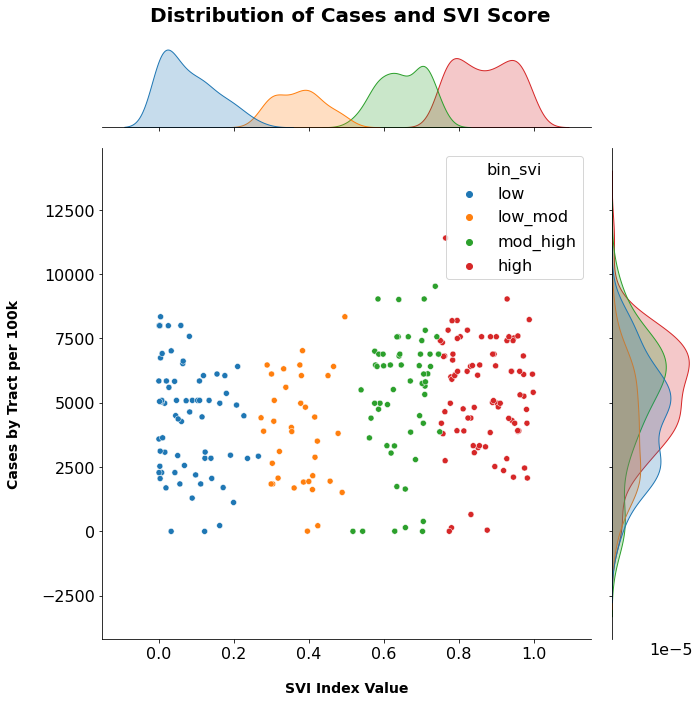

In [9]:
explore.joint_plot_index('raw_svi','tract_cases_per_100k', train_exp, 'bin_svi')

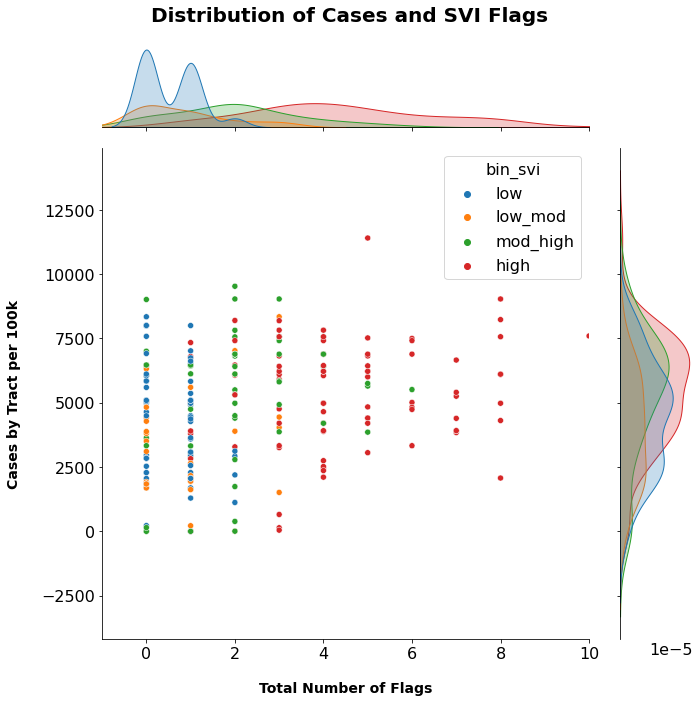

In [10]:
explore.joint_plot_flag("all_flags_total","tract_cases_per_100k",train_exp,'bin_svi')

In [33]:
hist_title = "Distribution of Cases in Dallas, TX: December 8th, 2020"

In [31]:
def hist_case_test(series, title):
    plt.figure(figsize=(12,8))
    plt.rc('font', size=16)
    plt.hist(x = series, bins = 10, color = 'gray', edgecolor='k', alpha=0.45)
    plt.title(title, y=1.02)
    plt.xlabel('Number of Cases per 100,000',labelpad=20)
    plt.ylabel('Case Count',labelpad=20)
    plt.axvline(series.mean(), color = 'tab:orange', linestyle='dashed', linewidth=5)
    min_ylim_v, max_ylim_v = plt.ylim()
    plt.text(series.mean()*1.05, max_ylim_v*0.9, 'Mean: {:.2f}'.format(series.mean()))
    # plt.axvline(series.median(), color = 'darkgreen', linestyle='dashed', linewidth=5)
    # plt.text(series.median()*.25, max_ylim_v*0.9, 'Median: {:.2f}'.format(series.median()))
    plt.grid(b = True, alpha = .45)
    # plt.figure(figsize = (16, 9))
    plt.tight_layout()
    plt.show()

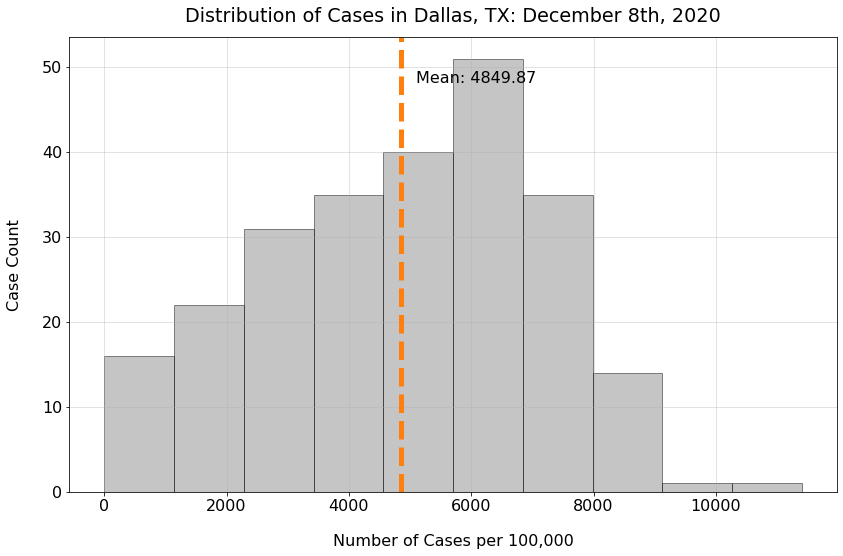

In [34]:
hist_case_test(train_exp.tract_cases_per_100k, hist_title)

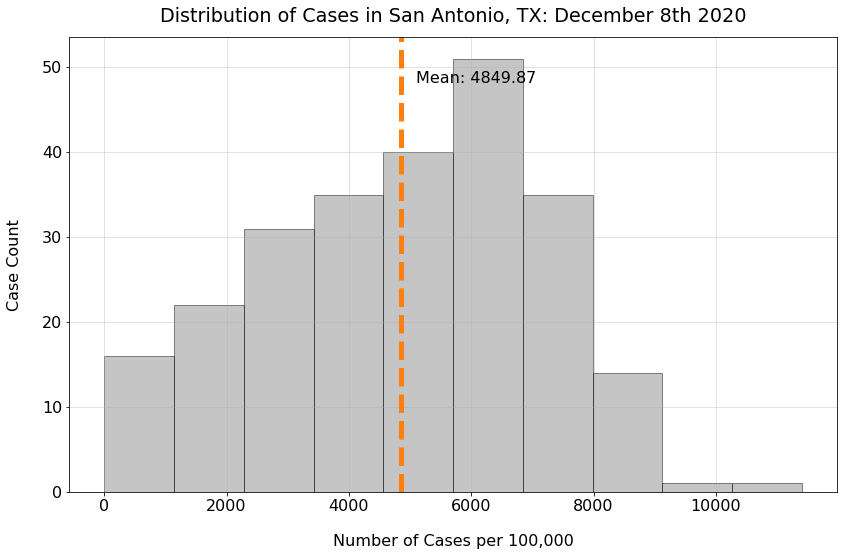

In [11]:
# Create a title variable, then change the function to accept a title variable.

explore.hist_case(train_exp.tract_cases_per_100k)

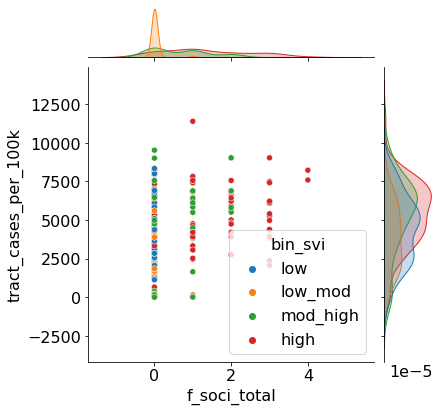

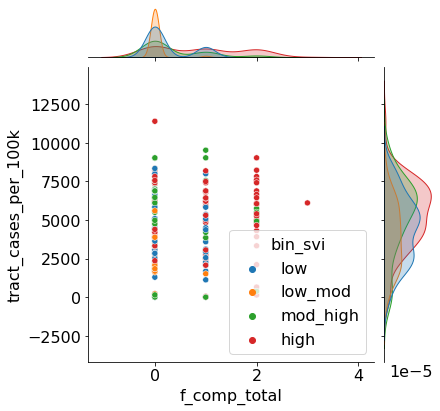

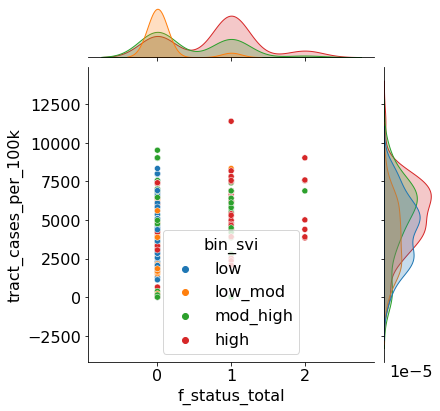

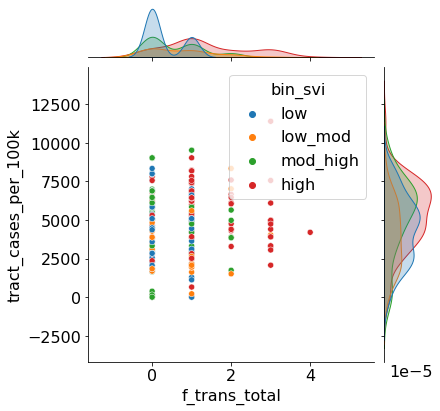

In [12]:
subtotal_flag_list = ['f_soci_total', 'f_comp_total', 'f_status_total', 'f_trans_total']
for col in subtotal_flag_list:
    sns.jointplot(x = col, y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi")

In [ ]:
subtotal_flag_list = ['f_soci_total', 'f_comp_total', 'f_status_total', 'f_trans_total']
for col in subtotal_flag_list:
    sns.jointplot(x = col, y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi")

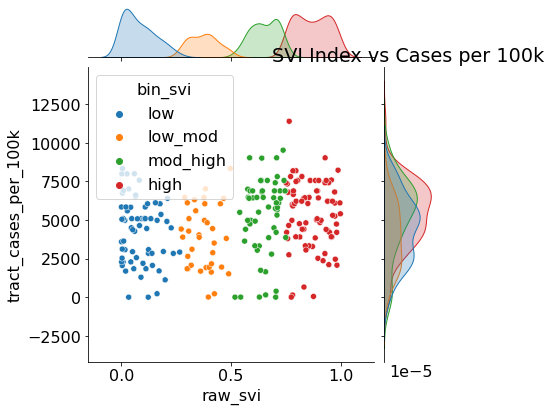

In [56]:

sns.jointplot(x = 'raw_svi', y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi")
# plt.figure(figsize = (16, 9))
plt.title("SVI Index vs Cases per 100k")
plt.show()

In [78]:
test_title = 45

In [80]:
print(f'This is a test of titles with the number {test_title}.')

This is a test of titles with the number 45.


AttributeError: 'JointGrid' object has no attribute 'set_legend'

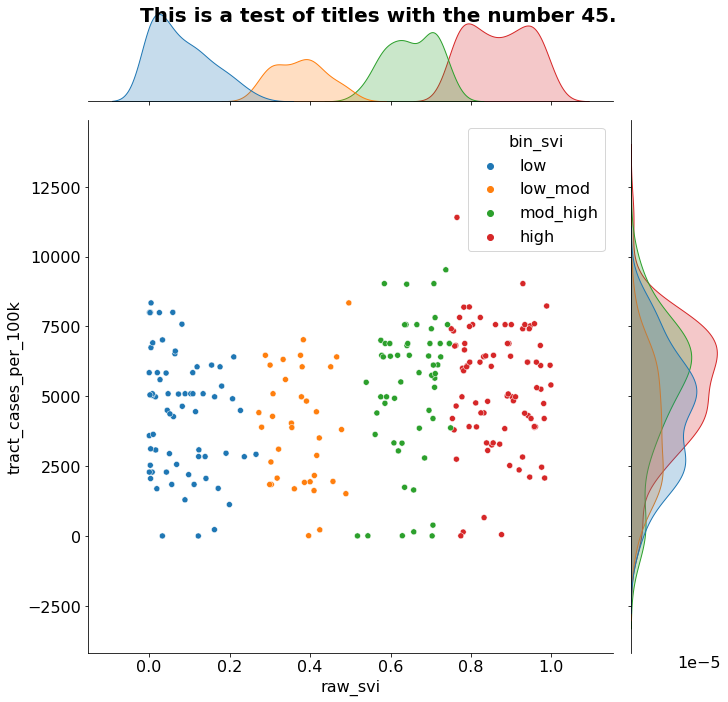

In [142]:
p = sns.jointplot(x = 'raw_svi', y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi", height = 8, size = 10)
p.fig.suptitle(f'This is a test of titles with the number {test_title}.', fontsize = 20, fontweight = 'bold')
p.set_legend(loc = 'upper_left')
p.set_axis_labels("SVI", "Cases per 100k", fontweight = 'bold')
p.fig.tight_layout()
# p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
plt.savefig("jointplot_columns")
plt.show()

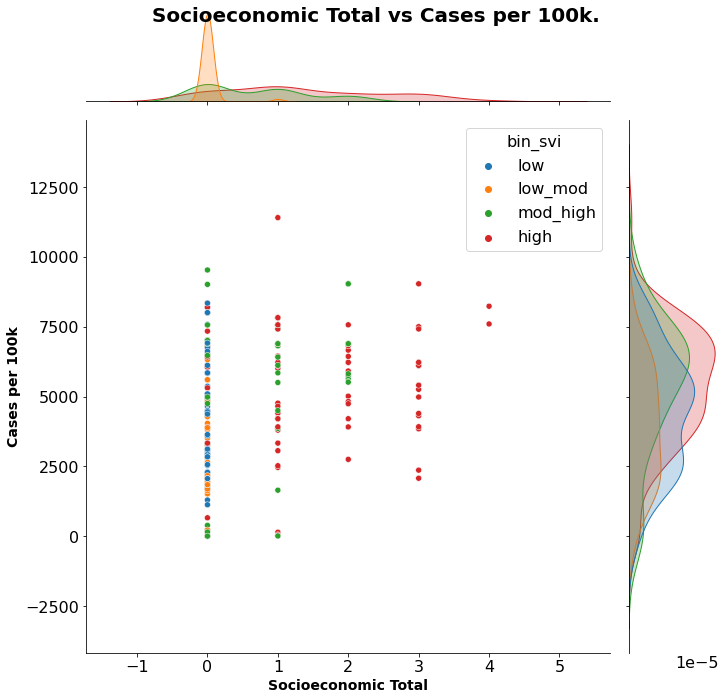

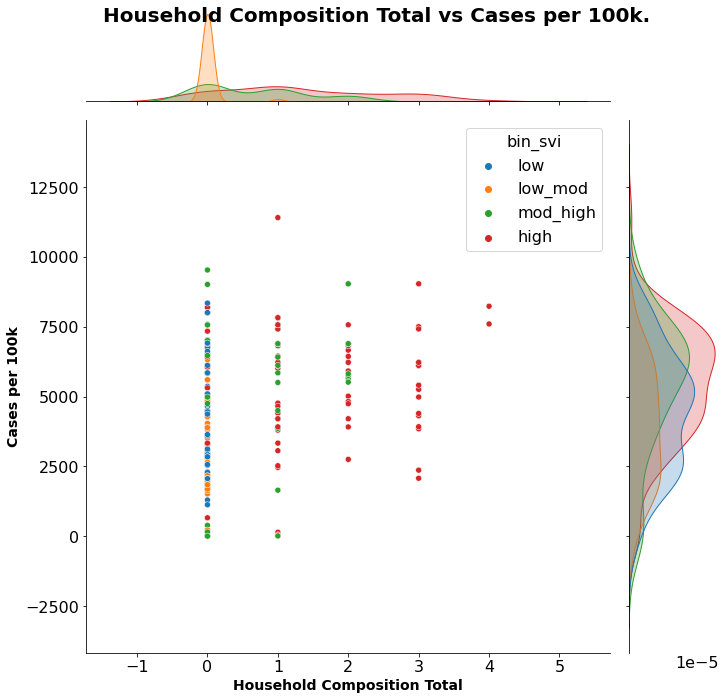

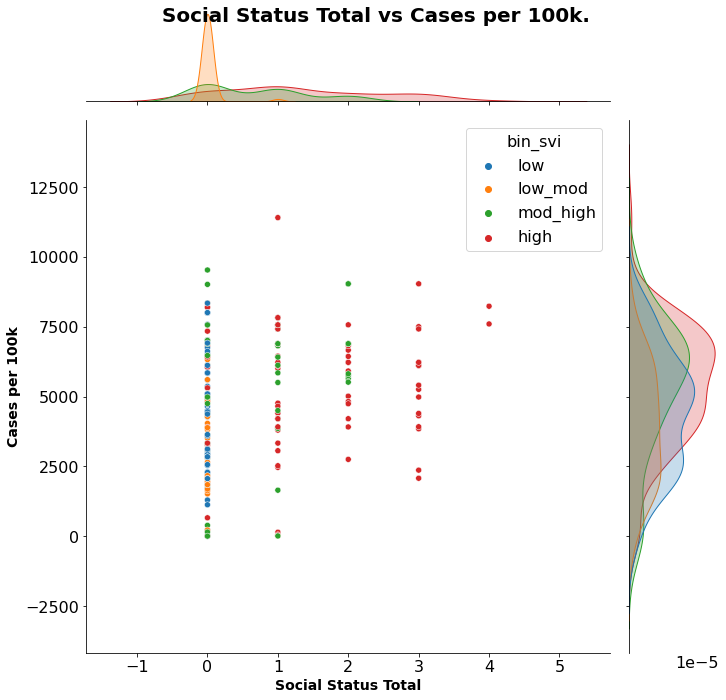

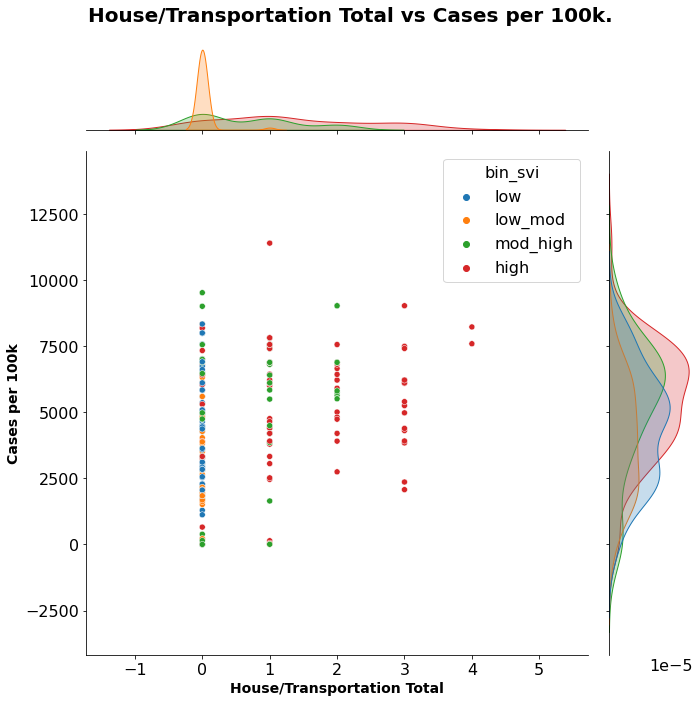

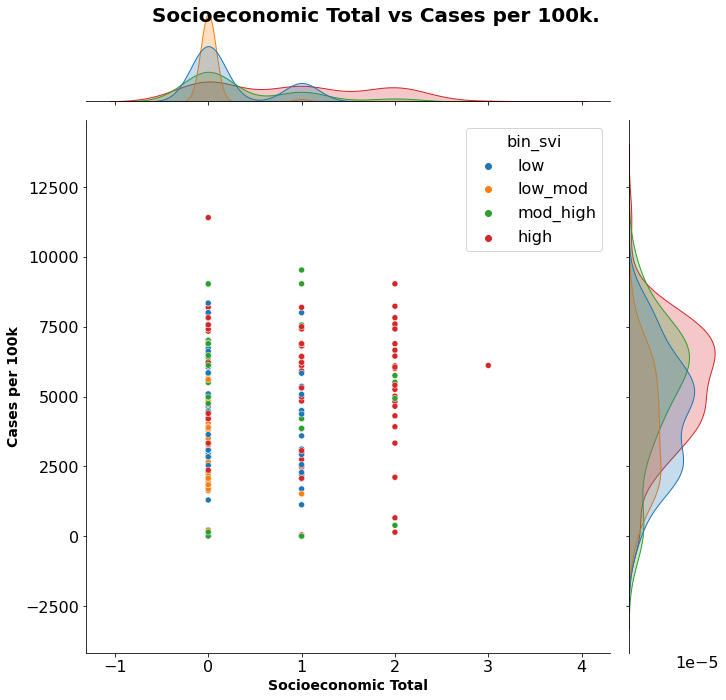

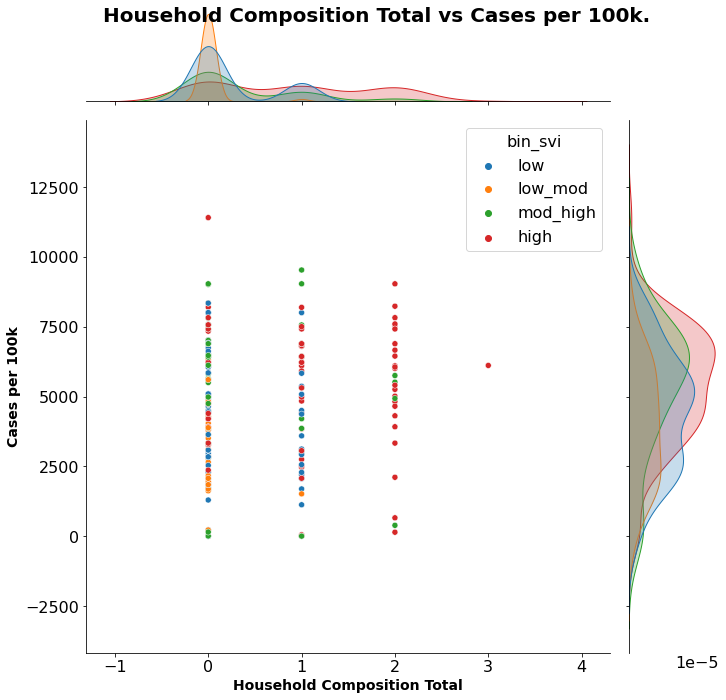

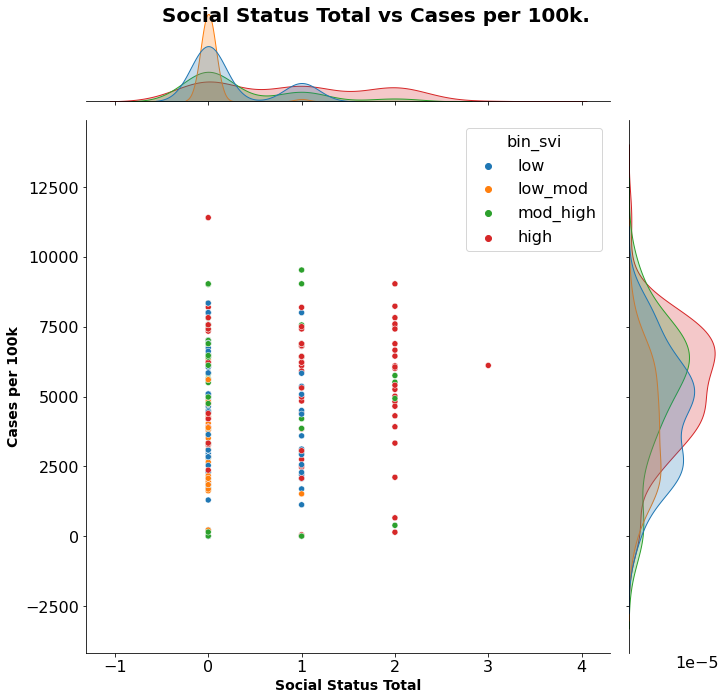

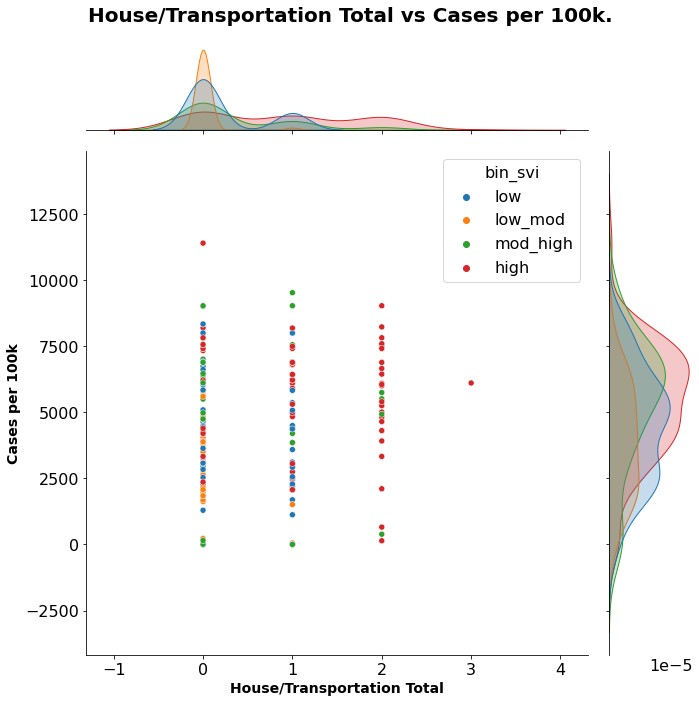

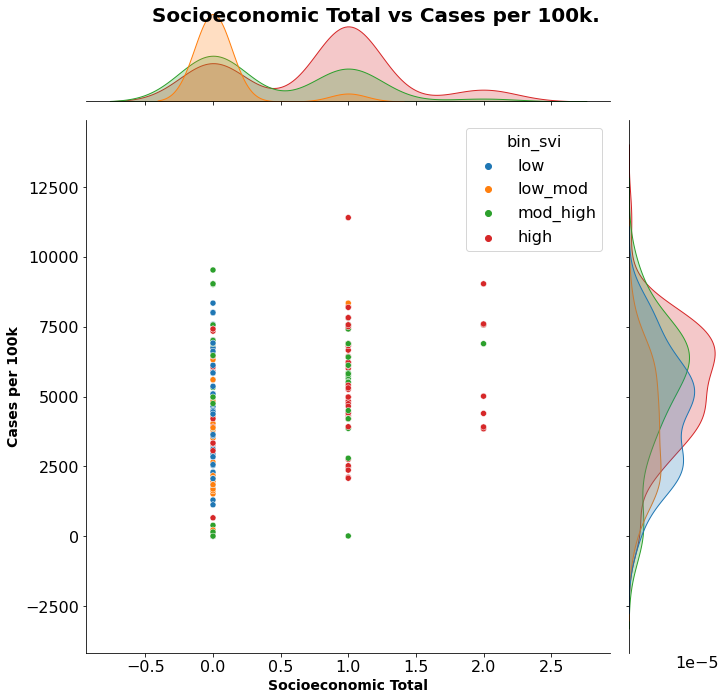

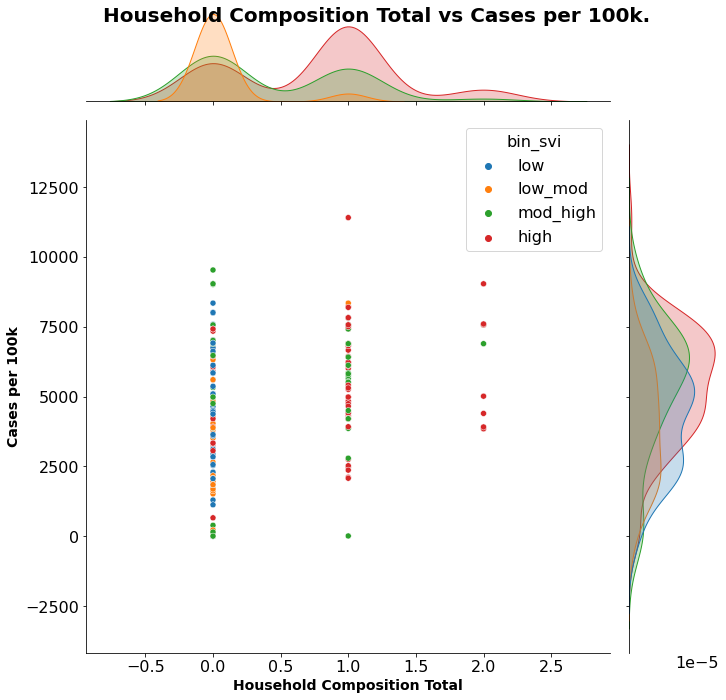

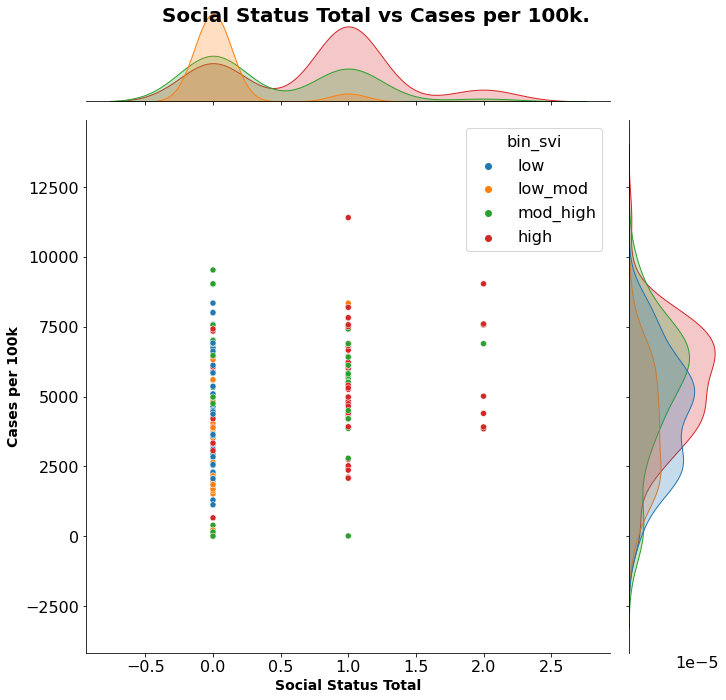

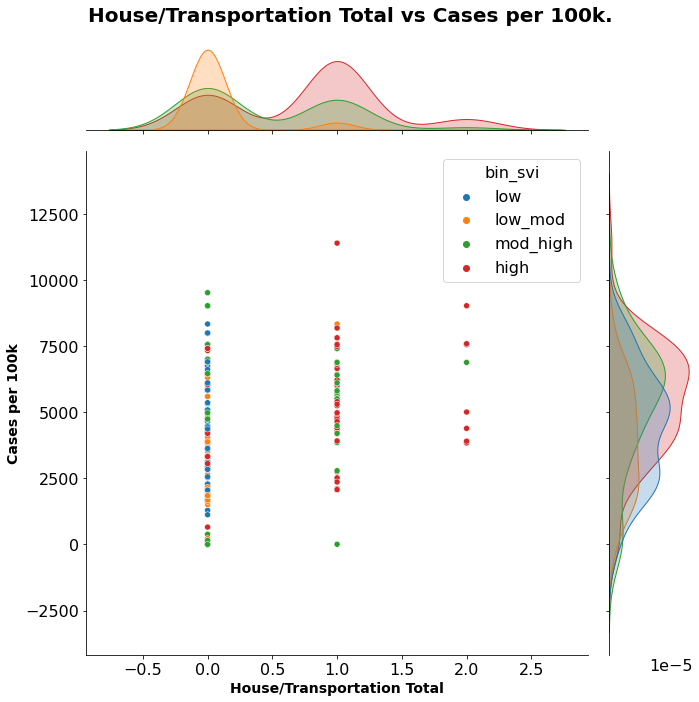

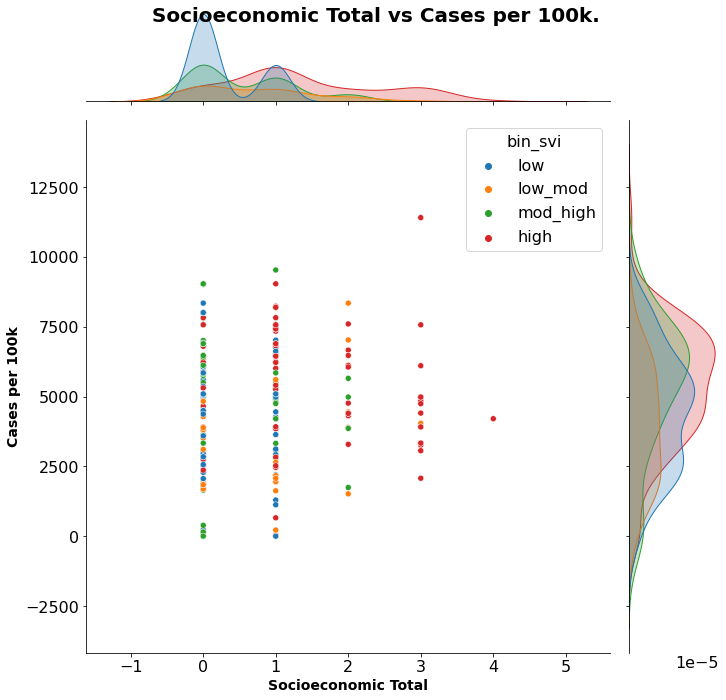

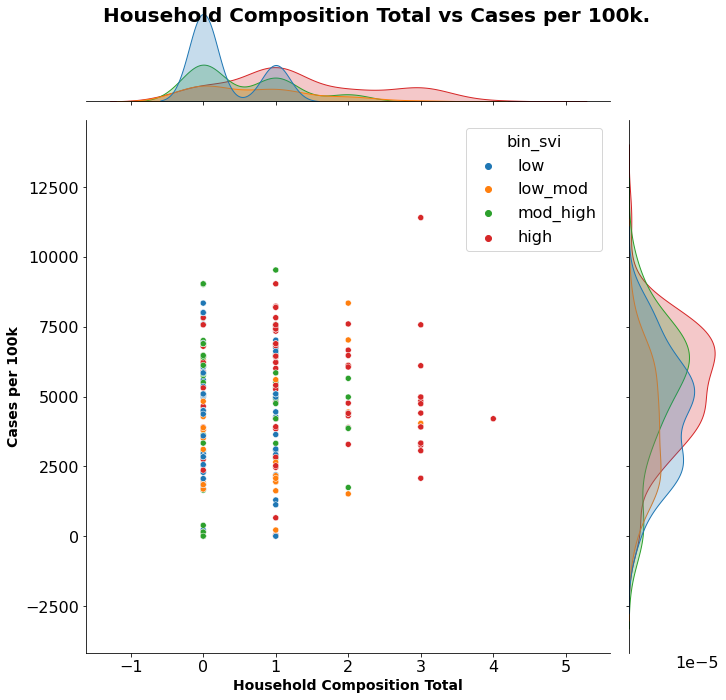

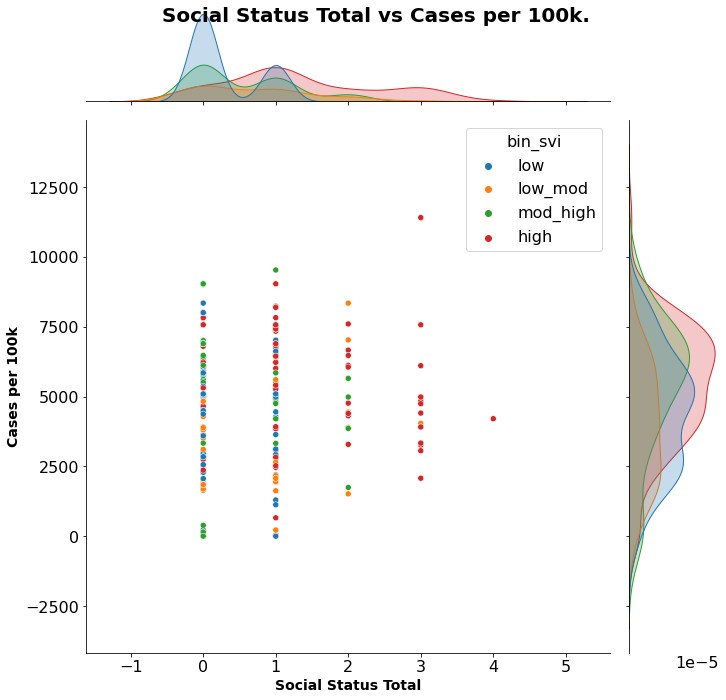

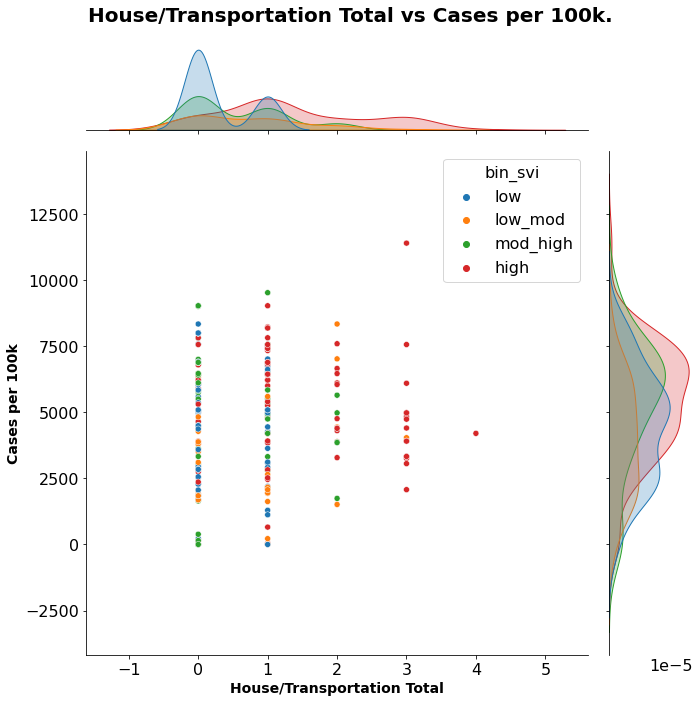

In [125]:
# Loop for the mini jointplots:

subtotal_flag_list = ['f_soci_total', 'f_comp_total', 'f_status_total', 'f_trans_total']

col_name_list = ["Socioeconomic Total", "Household Composition Total", "Social Status Total", "House/Transportation Total"]

for col in subtotal_flag_list:
    
    for x in col_name_list:
        p = sns.jointplot(x = col, y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi", height = 8, size = 10)
        p.fig.suptitle(f'{x} vs Cases per 100k.', fontsize = 20, fontweight = 'bold')
        p.set_axis_labels(f"{x}", "Cases per 100k", fontsize = 14, fontweight = 'bold')
    
#     for x in col_name_list:
#         p.fig.suptitle(f'{x} vs Cases per 100k.', fontsize = 20, fontweight = 'bold')
#         p.set_axis_labels(f"{x}", "Cases per 100k", fontsize = 14, fontweight = 'bold')
    p.fig.tight_layout()
    # p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    plt.savefig("jointplot_columns")
    plt.show()

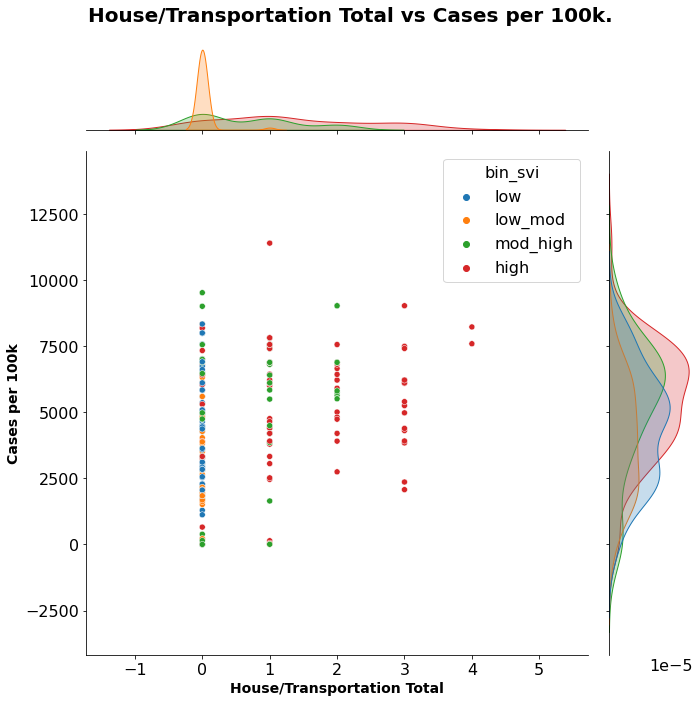

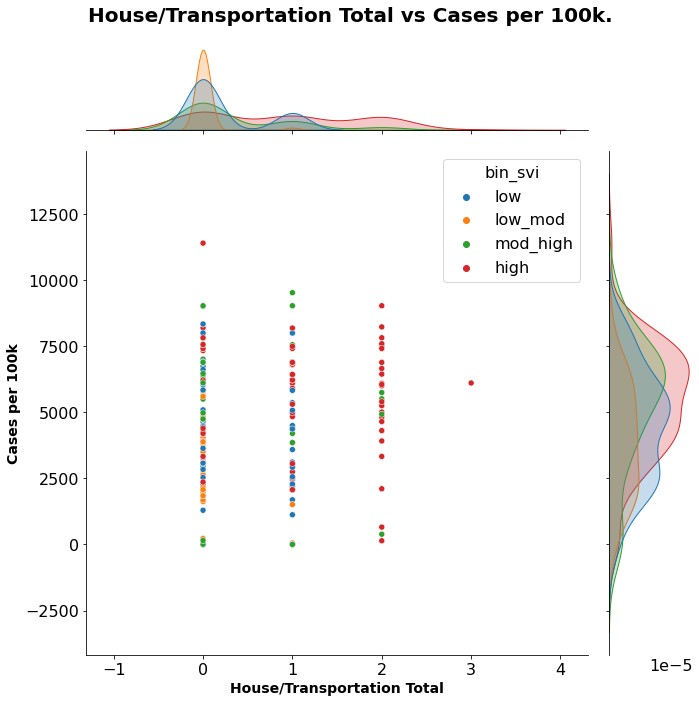

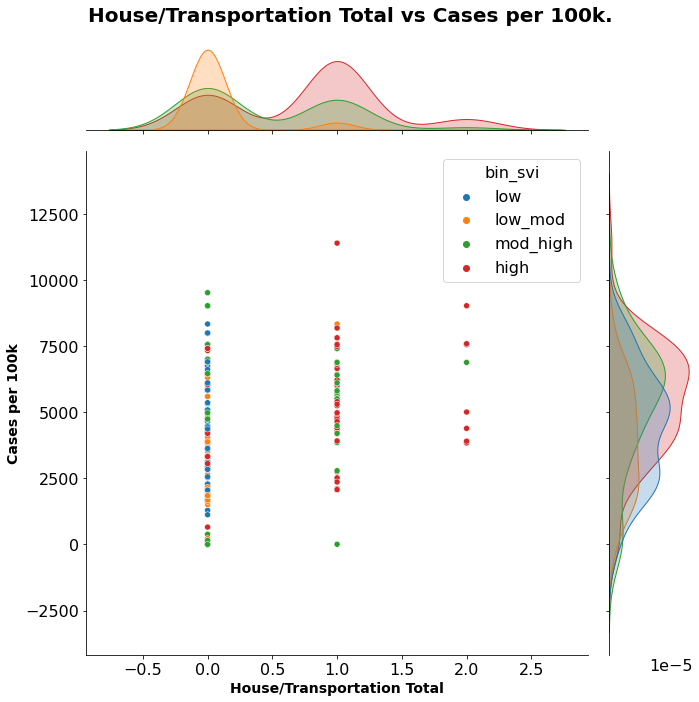

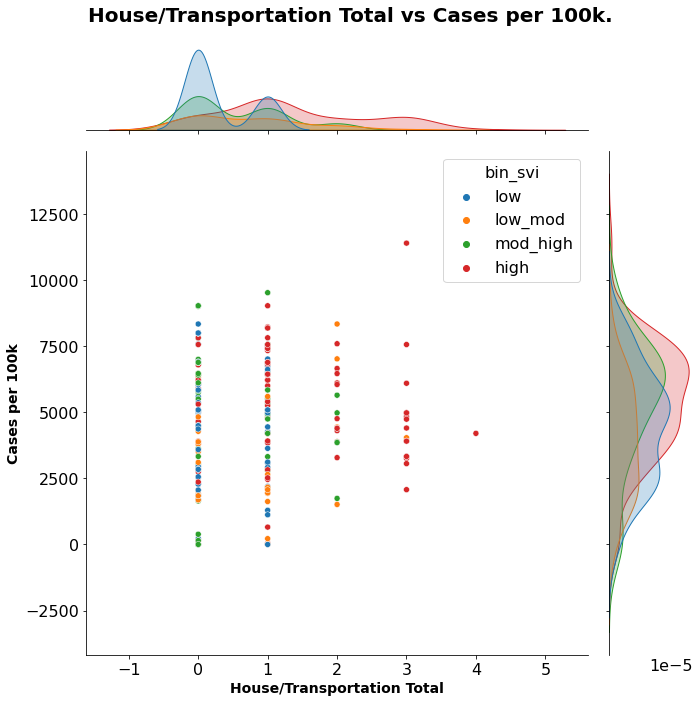

In [122]:
# Loop for the mini jointplots:

subtotal_flag_list = ['f_soci_total', 'f_comp_total', 'f_status_total', 'f_trans_total']

col_name_list = ["Socioeconomic Total", "Household Composition Total", "Social Status Total", "House/Transportation Total"]

for col in subtotal_flag_list:
    p = sns.jointplot(x = col, y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi", height = 8, size = 10)
    
    for x in col_name_list:
        p.fig.suptitle(f'{x} vs Cases per 100k.', fontsize = 20, fontweight = 'bold')
        p.set_axis_labels(f"{x}", "Cases per 100k", fontsize = 14, fontweight = 'bold')
    p.fig.tight_layout()
    # p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    plt.savefig("jointplot_columns")
    plt.show()

In [139]:
# Now write the function:

def my_plotter(df, col_x, col_x_title, col_y, col_y_title, hue = "bin_svi"):
    '''
    This function will return a jointplot with formatting. 
    You must input the x and y columns, x and y column names, the source dataframe, and the column by which the data has been binned.
    Note that col_x, col_y, col_x_title and col_y_title MUST BE STRINGS.
    '''
    # I may be able to force the input to be a string... but this'll do for the MVP.
#     col_x_str = str(col)
        
    p = sns.jointplot(x = col_x, y = col_y, data = df, hue = hue, height = 8, size = 10)
    p.fig.suptitle(f'{col_x_title} vs {col_y_title}', fontsize = 20, fontweight = 'bold')
    p.set_axis_labels(f'{col_x_title}', f'{col_y_title}', fontweight = 'bold')
    p.fig.tight_layout()
    # p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    plt.savefig("jointplot_columns")
#     plt.show()
    return p, plt.show()

In [135]:
my_plotter?

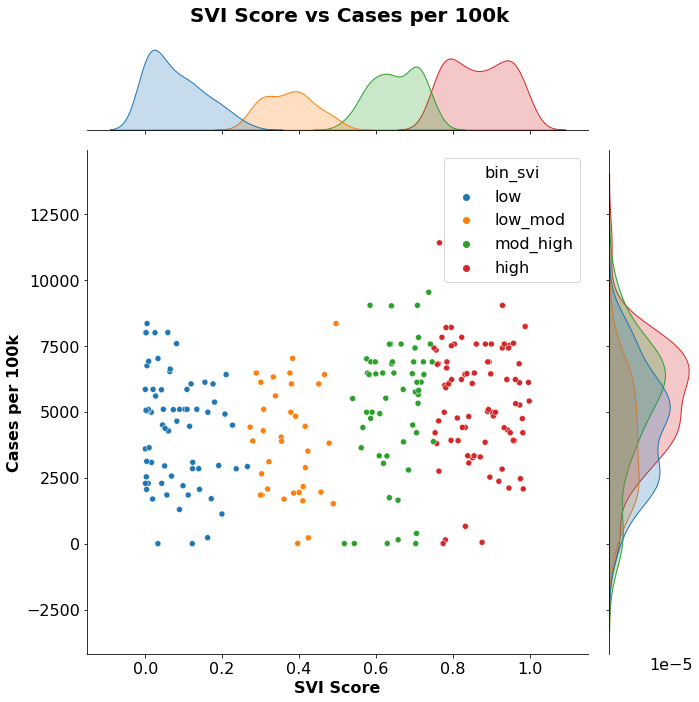

(<seaborn.axisgrid.JointGrid at 0x7faa2415a4d0>, None)

In [140]:
my_plotter(train_exp, 'raw_svi', "SVI Score", "tract_cases_per_100k", "Cases per 100k")

In [129]:
def my_string_test(string):
    string_test = str(string)
    return print(string_test), print(type(string_test))

In [131]:
my_string_test('hello')

hello
<class 'str'>


(None, None)

In [94]:
pp_columns = train_exp[['bin_svi', 'f_soci_total', 'f_comp_total', 'f_status_total', 'f_trans_total', 'raw_svi']]

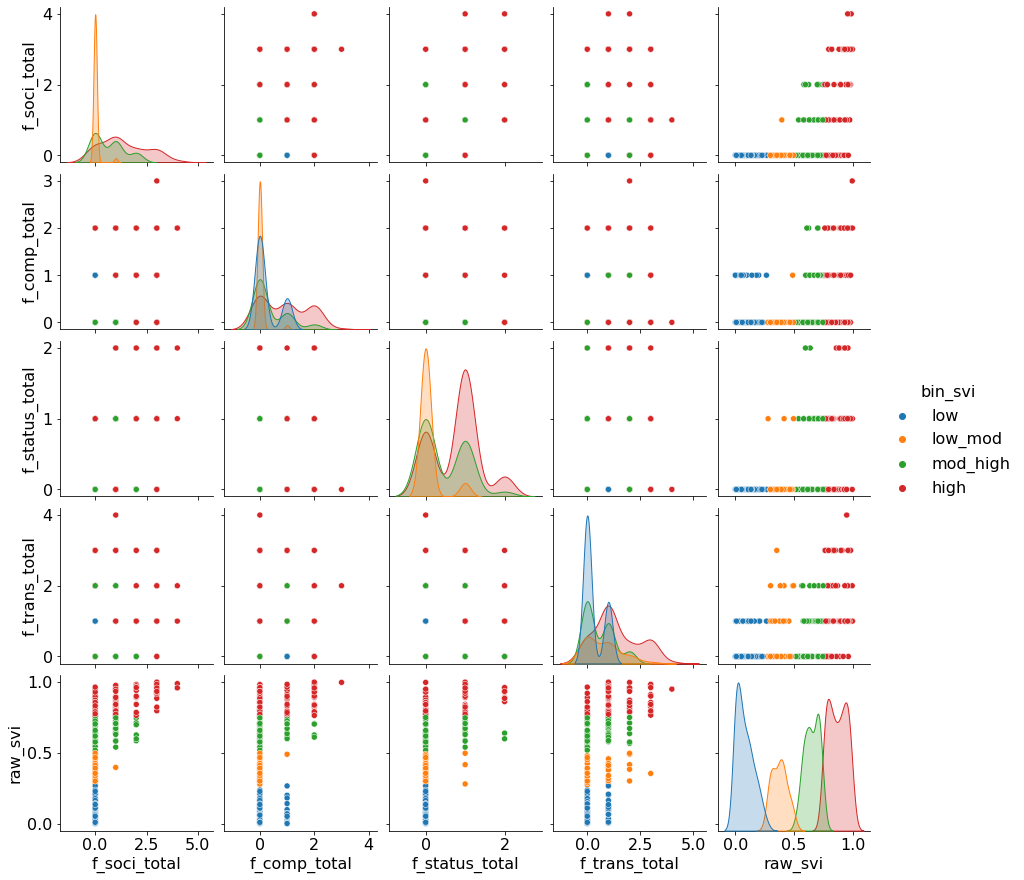

In [95]:
sns.pairplot(pp_columns, hue = "bin_svi")

# Model the Data

- Baseline for modeling determined by plotting the histogram distribution of COVID-19 cases per 100k.
- The skew observed in the distribution led us to use the median for this value instead of the mean??
- Used cross validation due to limited size of dataset. Size of dataset limited by San Antonio number of census tracts.
- Three of the 4 models used all of the features in the dataset, one model used only the top4 features identified by RFE.
- Linear Regression, LassoLars, and 2 degree polynomial features used all features and a 2nd version of 2 degree polynomial was run with just the top4 features.
- Of these the LassoLars had the least MAE (mean absolute error) and was run on out of sample data (test).
- This model had nearly identical MAE when run on out of sample data, only a 0.7 difference in MAE.
- Overall this is a 25% improvement from mean baseline MAE.

## Create Baseline

In [13]:
# What is the mean vs median of the target variable?
y_train.tract_cases_per_100k.mean(), y_train.tract_cases_per_100k.median()

(4849.866470319118, 5023.511679404)

In [14]:
# calculate the mean absolute error (MAE) of the baseline using mean
mean_baseMAE, basepred1 = model_MAE.get_baseline_mean(y_train)

Baseline MAE: 1861.849146190839


In [15]:
# calculate the mean absolute error (MAE) of the baseline using median
median_baseMAE, basepred2 = model_MAE.get_baseline_median(y_train)

Baseline MAE: 1850.786504453061


## Feature Ranking

- Use recursive feature elimination to evaluate features for modeling

In [16]:
rankdf = model_MAE.feature_ranking(X_train_scaled, y_train)
rankdf

,features
rank,
1,f_status_total_scaled
2,raw_svi
3,rank_svi_scaled
4,f_nohsdp_soci
5,f_age65_comp
6,f_noveh_trans
7,f_munit_trans
8,f_disabl_comp
9,all_flags_total_scaled


## Feature Selection

In [17]:
# only raw svi score
X_raw_svi = X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
X_rank_svi_only = X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
X_top4 = X_train_scaled[['rank_svi_scaled', 'f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans']]
# only the summary of the flags = 19th ranked
X_all_flags_only = X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
X_summary_flags = X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
X_not_summary_flags = X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]

## Build and Train Model

- Linear Regression, Polynomial Features, and Tweedie Regressor will be run with various combinations of features
- LassoLars will be run only with all of the features because feature evaluation is a component of the model

In [18]:
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Linear Regression Models
lm_MAE_list = []
for df in df2test:
    lm_MAE = model_MAE.linear_reg_train(df, target)
    lm_MAE_list.append(lm_MAE)

# Polynomial Features 2 degree
pf2_MAE_list = []
for df in df2test:
    pf2_MAE = model_MAE.polynomial2(df, target)
    pf2_MAE_list.append(pf2_MAE)

# Tweedie power=0, alpha=.5
tweedie05 = []
for df in df2test:
    tw_MAE = model_MAE.tweedie05(df, target)
    tweedie05.append(tw_MAE)


In [19]:
# LassoLars Models
lars_MAE = model_MAE.lasso_lars(X_train_scaled, target)

## Interpret the Model

In [20]:
# create dataframe for results of all train models
df_list = ['rank_svi_only', 'top4', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

results = pd.DataFrame(df_list, columns=['Features'])
results['LinearRegression_MAE'] = lm_MAE_list
results['Tweedie05_MAE'] = tweedie05
results['PolynomialFeatures2_MAE'] = pf2_MAE_list
results['LassoLars_MAE'] = lars_MAE
results['Base_mean_MAE'] = mean_baseMAE
results['Base_median_MAE'] = median_baseMAE
results.sort_values('PolynomialFeatures2_MAE')

,Features,LinearRegression_MAE,Tweedie05_MAE,PolynomialFeatures2_MAE,LassoLars_MAE,Base_mean_MAE,Base_median_MAE
5,all_features,1682.774142,1774.207667,1382.965641,1685.772151,1861.849146,1850.786504
4,not_summary_flags,1687.612609,1779.980315,1452.006741,1685.772151,1861.849146,1850.786504
3,summary_flags,1761.536336,1838.244251,1705.552654,1685.772151,1861.849146,1850.786504
1,top4,1736.509430,1808.500532,1713.454771,1685.772151,1861.849146,1850.786504
0,rank_svi_only,1837.754775,1848.642647,1837.809882,1685.772151,1861.849146,1850.786504
6,raw_svi_only,1839.824237,1853.418060,1842.738950,1685.772151,1861.849146,1850.786504
2,total_all_flags_only,1845.198345,1856.733564,1844.450520,1685.772151,1861.849146,1850.786504


## Cross Validation Modeling

- performed on top 4 models from initial modeling
- normally would start with this step as it encompasses both Train and Validate stages
    - LassoLars
    - LR all feature
    - PF2 all features
    - PF2 top5

In [21]:
from numpy import mean
from numpy import std, absolute
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

In [22]:
# LassoLars
# create loocv procedure
cvLL = LeaveOneOut()
# create model
modelLL = LassoLars(alpha=1)
# evaluate model
scoresLL = cross_val_score(modelLL, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cvLL, n_jobs=-1)
# force positive
scoresLL = absolute(scoresLL)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresLL), std(scoresLL)))

MAE: 1798.290 (1286.970)


In [23]:
# Linear Regression - all features
# create loocv procedure
cvLR = LeaveOneOut()
# create model
modelLR = LinearRegression()
# evaluate model
scoresLR = cross_val_score(modelLR, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cvLR, n_jobs=-1)
# force positive
scoresLR = absolute(scoresLR)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresLR), std(scoresLR)))

MAE: 1821.096 (1303.745)


In [24]:
# Polynomial Features 2 degrees - all features
# create loocv procedure
cvPF1 = LeaveOneOut()

# create PF object
pf1 = PolynomialFeatures(degree=2)
# Fit and Transform model to get a new set of features...which are the original features squared
X_train_squared1 = pf1.fit_transform(X_train_scaled)

# create model
modelPF1 = LinearRegression(normalize=True)
# evaluate model
scoresPF1 = cross_val_score(modelPF1, X_train_squared1, y_train, scoring='neg_mean_absolute_error', cv=cvPF1, n_jobs=-1)
# force positive
scoresPF1 = absolute(scoresPF1)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresPF1), std(scoresPF1)))

MAE: 1222335136242482.750 (5264743756874851.000)


In [25]:
# Polynomial Features 2 degrees - top 5
# create loocv procedure
cvPF2 = LeaveOneOut()

# create PF object
pf2 = PolynomialFeatures(degree=2)
# Fit and Transform model to get a new set of features...which are the original features squared
X_train_squared2 = pf2.fit_transform(X_top4)

# create model
modelPF2 = LinearRegression(normalize=True)
# evaluate model
scoresPF2 = cross_val_score(modelPF2, X_train_squared2, y_train, scoring='neg_mean_absolute_error', cv=cvPF2, n_jobs=-1)
# force positive
scoresPF2 = absolute(scoresPF2)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresPF2), std(scoresPF2)))

MAE: 1820.069 (1286.147)


## Test Stage

In [26]:
# fit model from cross validation to train dataset
modelLL.fit(X_train_scaled, y_train)
# use the trained dataset to predict on test
lars_test_pred = modelLL.predict(X_test_scaled)
# get the MAE of test
lars_MAE = mean_absolute_error(y_test, lars_test_pred)
print('MAE: %.3f' % lars_MAE)

MAE: 1981.855


#### Report Metrics in Context
How did the model perform on the key metrics you chose to demonstrate its usefulness? What counts as good or bad performance? How well do humans perform on this task? How well would you expect to do with random dice rolls? What are the costs associated with missed predictions?

In [27]:
# 2-3 sentances about what LASSOLARS does (how it works)
# If we can get a viz on lassolars visual coeficients (use placeholder).
# Coef rankings (dataframe)
# Text clarifying all the coeficents, simple definitions of what each flag means (add those def strings to dataframe)
# Run the dallas data thru the same MVP process, and discover what the top 5 features are, and on they different than SAs?

In [28]:
# LASSOLARS Results table:
# import pandas as pd

ll_result = pd.DataFrame()
x_train_columns = X_train_scaled.columns.tolist()
ll_result['features'] = x_train_columns
ll_result['coefs'] = modelLL.coef_
ll_result['abs_coefs'] = abs(modelLL.coef_)
ll_result.sort_values(by = 'abs_coefs', ascending = False)

,features,coefs,abs_coefs
18,f_status_total_scaled,1346.653896,1346.653896
4,f_nohsdp_soci,1185.622761,1185.622761
5,f_age65_comp,-988.148937,988.148937
0,raw_svi,-817.813436,817.813436
14,f_noveh_trans,701.395528,701.395528
7,f_disabl_comp,594.830115,594.830115
11,f_munit_trans,-528.289419,528.289419
1,f_pov_soci,-386.044019,386.044019
15,f_groupq_trans,-308.145747,308.145747
6,f_age17_comp,267.385569,267.385569


#### LASSO+LARS Results:

In [29]:
# Table of top features:

ll_results_tbl = pd.Series(dict(zip(X_train_scaled.columns, modelLL.coef_.ravel()))).sort_values()
ll_results_tbl

f_age65_comp              -988.148937
raw_svi                   -817.813436
f_munit_trans             -528.289419
f_pov_soci                -386.044019
f_groupq_trans            -308.145747
rank_svi_scaled           -195.555801
f_sngpnt_comp                0.000000
f_minrty_status              0.000000
all_flags_total_scaled       0.000000
f_pci_soci                   0.000000
f_mobile_trans               0.000000
f_unemp_soci                 0.000000
f_soci_total_scaled          0.000000
f_comp_total_scaled          0.000000
f_trans_total_scaled         0.000000
f_limeng_status             18.752298
f_crowd_trans               61.535225
f_age17_comp               267.385569
f_disabl_comp              594.830115
f_noveh_trans              701.395528
f_nohsdp_soci             1185.622761
f_status_total_scaled     1346.653896
dtype: float64

(-1.6662037146572912, -0.0)

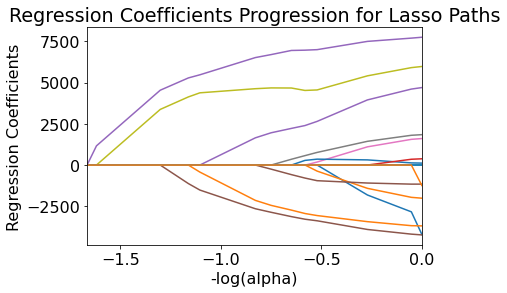

In [30]:
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline

ax = plt.gca()

m_log_alphas = -np.log10(modelLL.alphas_) # alpha contains the values of alpha through the model selection process.
plt.plot(m_log_alphas, modelLL.coef_path_.T) # change in regression coefficient
np.shape(modelLL.coef_path_), np.shape(m_log_alphas)

# plt.axvline(-np.log10(modelLL.alphas_), linestyle='--', color='k',
#             label='alpha CV')

plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
ax.set_xlim(m_log_alphas.min(), m_log_alphas.max())

#### Strengths and Weaknesses

Once you've gone through your iteration cycles and are finished with this version of the model, or this particular project, provide an assessment of what types of observations are handled well by your model, and what circumstances seem to give it trouble. This will point you and others towards more questions for future projects.

#### Inspect Errors

Look at some of the observations with missed predictions. (Do this in your validation set, never look at individual records in your test set!) Are there common patterns among the observations with bad results? Do you have data that you can include in your model that will capture these patterns or is this a task that will need another research project to solve?

This is your last step in the iteration cycle; if you can't find anything else you can work on here with your present data, project scope, and deadlines, then it's time to wrap things up.

# Next Steps: What Can We Do Now?

Reporting a model's results is good, and is the main objective of any data science project. But a project is one thing, a career is another. A question is one thing, but science is another. If you've carried out your research with a mindset of curiosity and creativity, then by now you should have plenty more, and much better informed, questions about this topic than what you started with.

So in addition to reporting on the question you investigated and the answers you found, think of the needs of your team, your users, and your peers in the industry, and make some recommendations that answer these two questions:

What are some unanswered questions in my project where more information (additional data sources, deeper understanding, other models or tools) might help improve these results?
What are other needs or problems where my model or my approach may be useful?

 ## additional models to try
- random forest regressor
- decission tree regressor
- support vector regressor
- multiple linear regressor

https://github.com/CSolitaire/machine-learning-course/tree/master/Machine%20Learning%20Toolkit/Regression%20Templates

## Is San Antonio different from other cities?

- Dallas?
- Pittsburgh?
- Phoenix?
- ??
- ??

## Feature Engineering

- SVI trend for the county
    - is rising? is declining? 
    - delta of SVI change year over year?
    - std dev of SVI?
